# **Part 1: Introduction to Regression Problem**

### Air Quality Dataset Overview

- The dataset includes 9358 hourly readings from 5 metal oxide chemical sensors in an Air Quality Monitoring Device, deployed at road level in a polluted Italian city from March 2004 to February 2005. It provides ground truth concentrations for CO, Non-Methanic Hydrocarbons, Benzene, NOx, and NO2 from a certified analyzer. Sensor data show cross-sensitivities, concept drift, and sensor drift, potentially impacting concentration estimation, as detailed in De Vito et al., Sens. Act. B, Vol. 129, 2008. Missing values are tagged with -200 value.

### Feature Descriptions
------------------------------

- 0 Date (DD/MM/YYYY)
- 1 Time (HH.MM.SS)
- 2 True hourly averaged concentration CO in mg/m^3 (reference analyzer)
- 3 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
- 4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
- 5 True hourly averaged Benzene concentration in microg/m^3 (target variable)
- 6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
- 7 True hourly averaged NOx concentration in ppb (reference analyzer)
- 8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
- 9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
- 10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
- 11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
- 12 Temperature in Â°C
- 13 Relative Humidity (%)
- 14 AH Absolute Humidity




# **Importing Libraries**

Lets first import all the sufficient libraries for the upcoming operations

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', palette='viridis')

from sklearn.preprocessing import StandardScaler

from sklearn.impute import KNNImputer

from sklearn.model_selection import learning_curve

from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                            accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix, classification_report)

from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import Ridge

from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer

import shap
from lime.lime_tabular import LimeTabularExplainer
import lime

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.utils import class_weight

# **Data Preprocessing**

Okay, Since all the sufficient libraries are imported, let's discover some data insights and fix the issues

In [ ]:
df = pd.read_excel('/content/AirQualityUCI.xlsx')

In [ ]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [ ]:
df.shape

(9357, 15)

So we have 14 independent variables with 1 target column and 9357 instances

In [ ]:
df.tail()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9352,2005-04-04,10:00:00,3.1,1314.25,-200,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250,0.756824
9353,2005-04-04,11:00:00,2.4,1162.50,-200,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725,0.711864
9354,2005-04-04,12:00:00,2.4,1142.00,-200,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350,0.640649
9355,2005-04-04,13:00:00,2.1,1002.50,-200,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550,0.513866
9356,2005-04-04,14:00:00,2.2,1070.75,-200,11.932060,1047.25,265.2,654.00,167.7,1128.50,816.00,28.500,13.125,0.502804


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   int64         
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   float64       
dtypes: datetime64[ns](1),

So we see that there are no null values, but from the data description we know that our missing values are -200s, lets do a little research to find out some null patterns


In [ ]:
missing_percentages = (df == -200).sum() / len(df) * 100
missing_percentages

,0
Date,0.000000
Time,0.000000
CO(GT),17.986534
PT08.S1(CO),3.911510
NMHC(GT),90.231912
C6H6(GT),3.911510
PT08.S2(NMHC),3.911510
NOx(GT),17.516298
PT08.S3(NOx),3.911510
NO2(GT),17.548360


Okay, we got a little pattern here, so as we can see there are lots of same null(-200) percentages, which means that some rows are just not filled, so we have to get rid of those rows, there is no point to fill them

In [ ]:
rows_with_many_missing = (df == -200).sum(axis=1) >=9
percentage_rows_many_missing = (rows_with_many_missing.sum() / len(df)) * 100

print(f"{percentage_rows_many_missing:.6f}% of rows have more than 9 missing values.")

3.911510% of rows have more than 9 missing values.


Now lets clean those rows that are missing values in the mentioned 9 columns

In [ ]:
df_cleaned_temp = df[~rows_with_many_missing]
missing_percentages_cleaned = (df_cleaned_temp == -200).sum() / len(df_cleaned_temp) * 100
missing_percentages_cleaned

,0
Date,0.000000
Time,0.000000
CO(GT),18.318318
PT08.S1(CO),0.000000
NMHC(GT),90.134579
C6H6(GT),0.000000
PT08.S2(NMHC),0.000000
NOx(GT),17.739962
PT08.S3(NOx),0.000000
NO2(GT),17.773329


They are gone, now we have left only the normal -200 missing values, for which I am gonna use KNN imputer, because I think it is the best practice and would be suitable for our situation as well

In [ ]:
df_cleaned_temp = df_cleaned_temp.drop(columns=['NMHC(GT)'])

df_cleaned_temp = df_cleaned_temp.replace(-200, np.nan)

numeric_cols = df_cleaned_temp.select_dtypes(include=['number']).columns
non_numeric_cols = df_cleaned_temp.select_dtypes(exclude=['number']).columns

knn_imputer = KNNImputer(n_neighbors=5)
numeric_data = pd.DataFrame(knn_imputer.fit_transform(df_cleaned_temp[numeric_cols]), columns=numeric_cols)

df_imputed = pd.concat([numeric_data, df_cleaned_temp[non_numeric_cols].reset_index(drop=True)], axis=1)

In [ ]:
df_imputed.isna().sum()

,0
CO(GT),0
PT08.S1(CO),0
C6H6(GT),0
PT08.S2(NMHC),0
NOx(GT),0
PT08.S3(NOx),0
NO2(GT),0
PT08.S4(NO2),0
PT08.S5(O3),0
T,0


Done! We have fully imputed data

In [ ]:
df = df_imputed

In [ ]:
df.head().T

,0,1,2,3,4
CO(GT),2.6,2.0,2.2,2.2,1.6
PT08.S1(CO),1360.0,1292.25,1402.0,1375.5,1272.25
C6H6(GT),11.881723,9.397165,8.997817,9.228796,6.518224
PT08.S2(NMHC),1045.5,954.75,939.25,948.25,835.5
NOx(GT),166.0,103.0,131.0,172.0,131.0
PT08.S3(NOx),1056.25,1173.75,1140.0,1092.0,1205.0
NO2(GT),113.0,92.0,114.0,122.0,116.0
PT08.S4(NO2),1692.0,1558.75,1554.5,1583.75,1490.0
PT08.S5(O3),1267.5,972.25,1074.0,1203.25,1110.0
T,13.6,13.3,11.9,11.0,11.15


Now lets merge the Date and Time columns and make the time series split according to the DateTime column

In [ ]:
df['Datetime'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Time'].astype(str))

df = df.drop(columns=['Date', 'Time'])

In [ ]:
df = df.sort_values(by='Datetime')

X = df.drop(columns=['C6H6(GT)', 'Datetime'])
y = df['C6H6(GT)']

train_size = 0.8
train_index = int(len(df) * train_size)

X_train, X_test = X.iloc[:train_index], X.iloc[train_index:]
y_train, y_test = y.iloc[:train_index], y.iloc[train_index:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7192, 11)
X_test shape: (1799, 11)
y_train shape: (7192,)
y_test shape: (1799,)


Done! Time to build some tree based models on our dataset

# **Model Building and Evaluation**

## **Decision Tree Regressor**

In [ ]:
dt_regressor = DecisionTreeRegressor()

dt_regressor.fit(X_train, y_train)

y_pred = dt_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 0.0003165751092988561
R-squared (R2): 0.9999925413685428


So our basic, non-tuned decision tree regression model seems to have an amazing metrics, almost perfect I would say, lets now plot our decision trees with different depth and see if we spot any differences

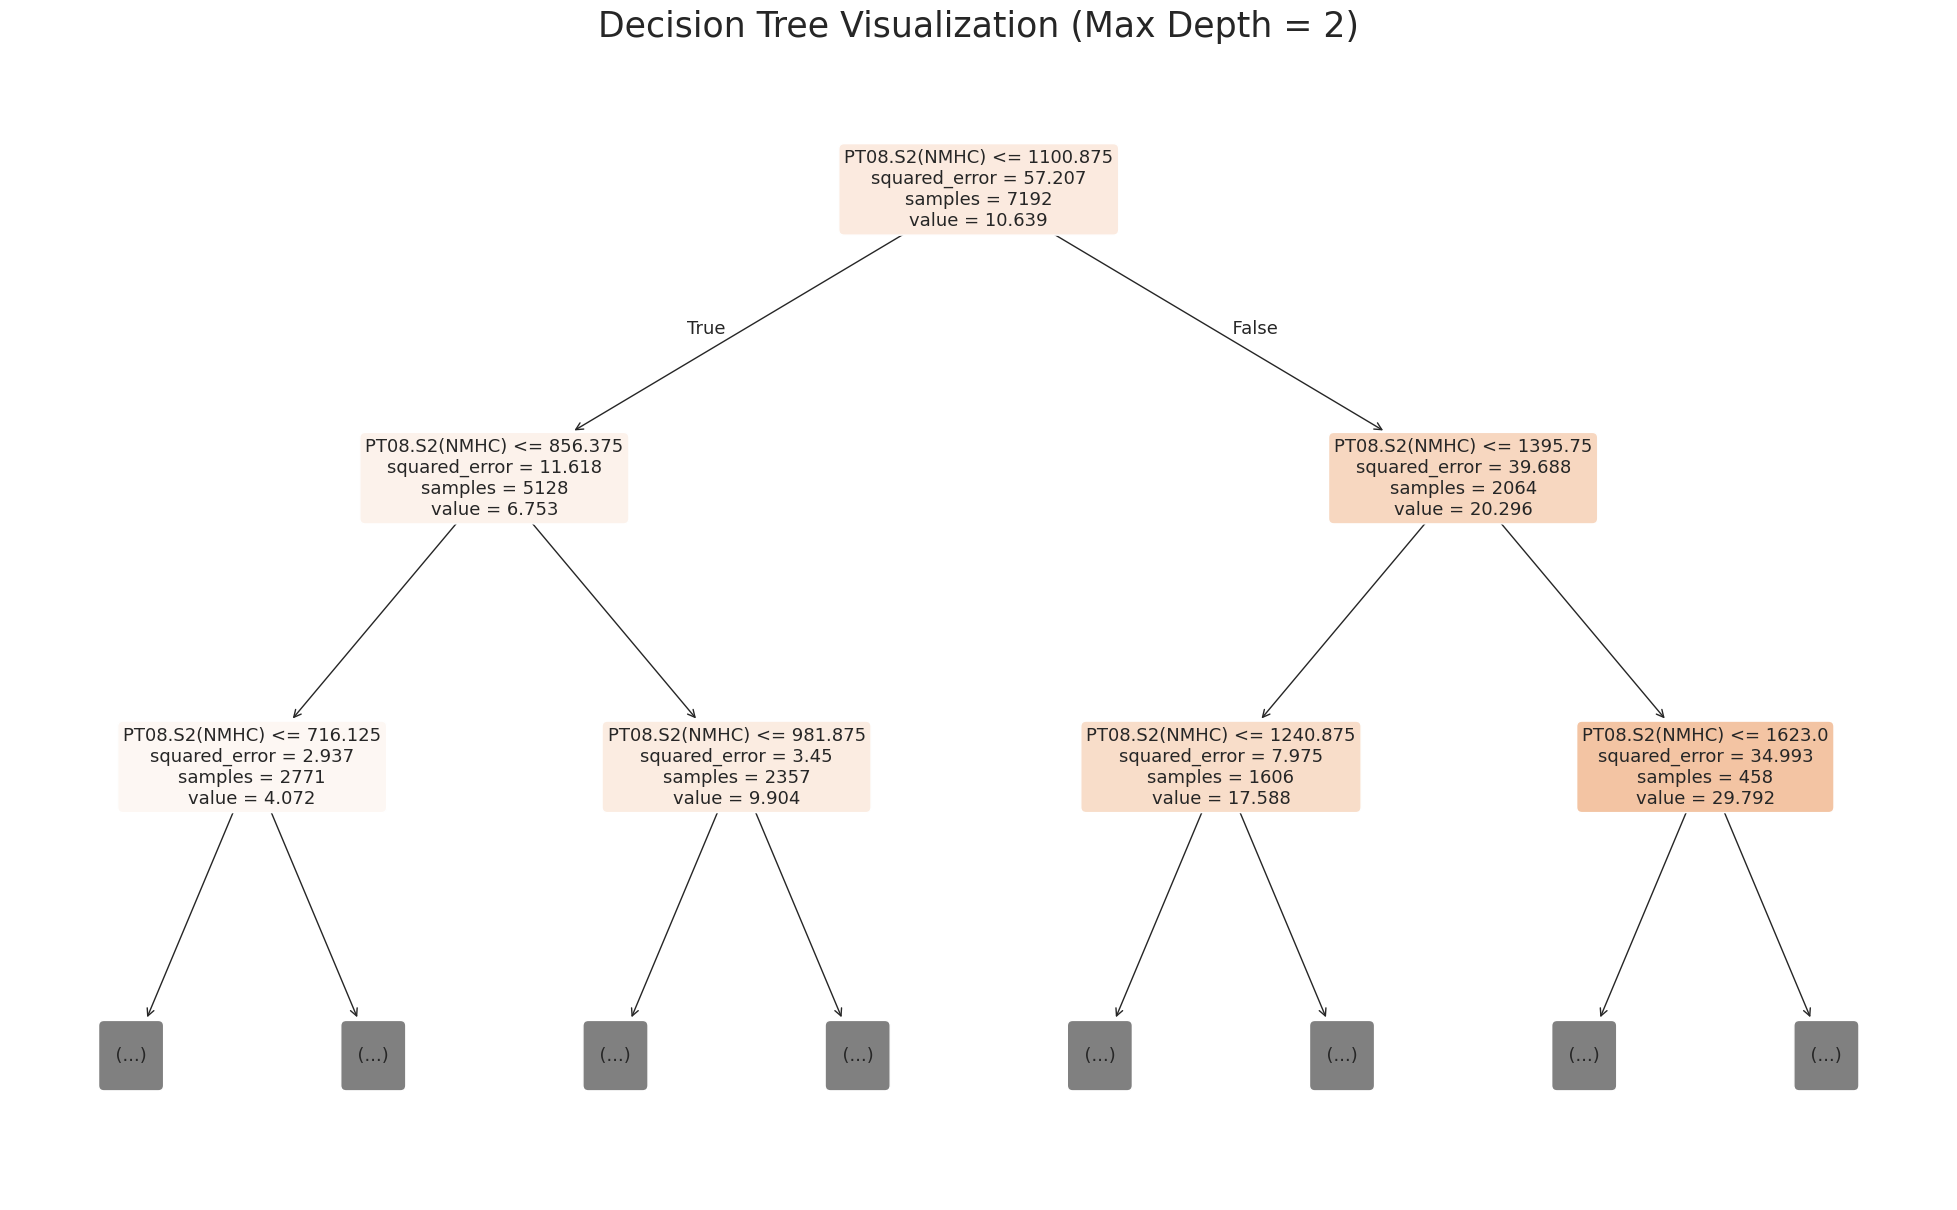

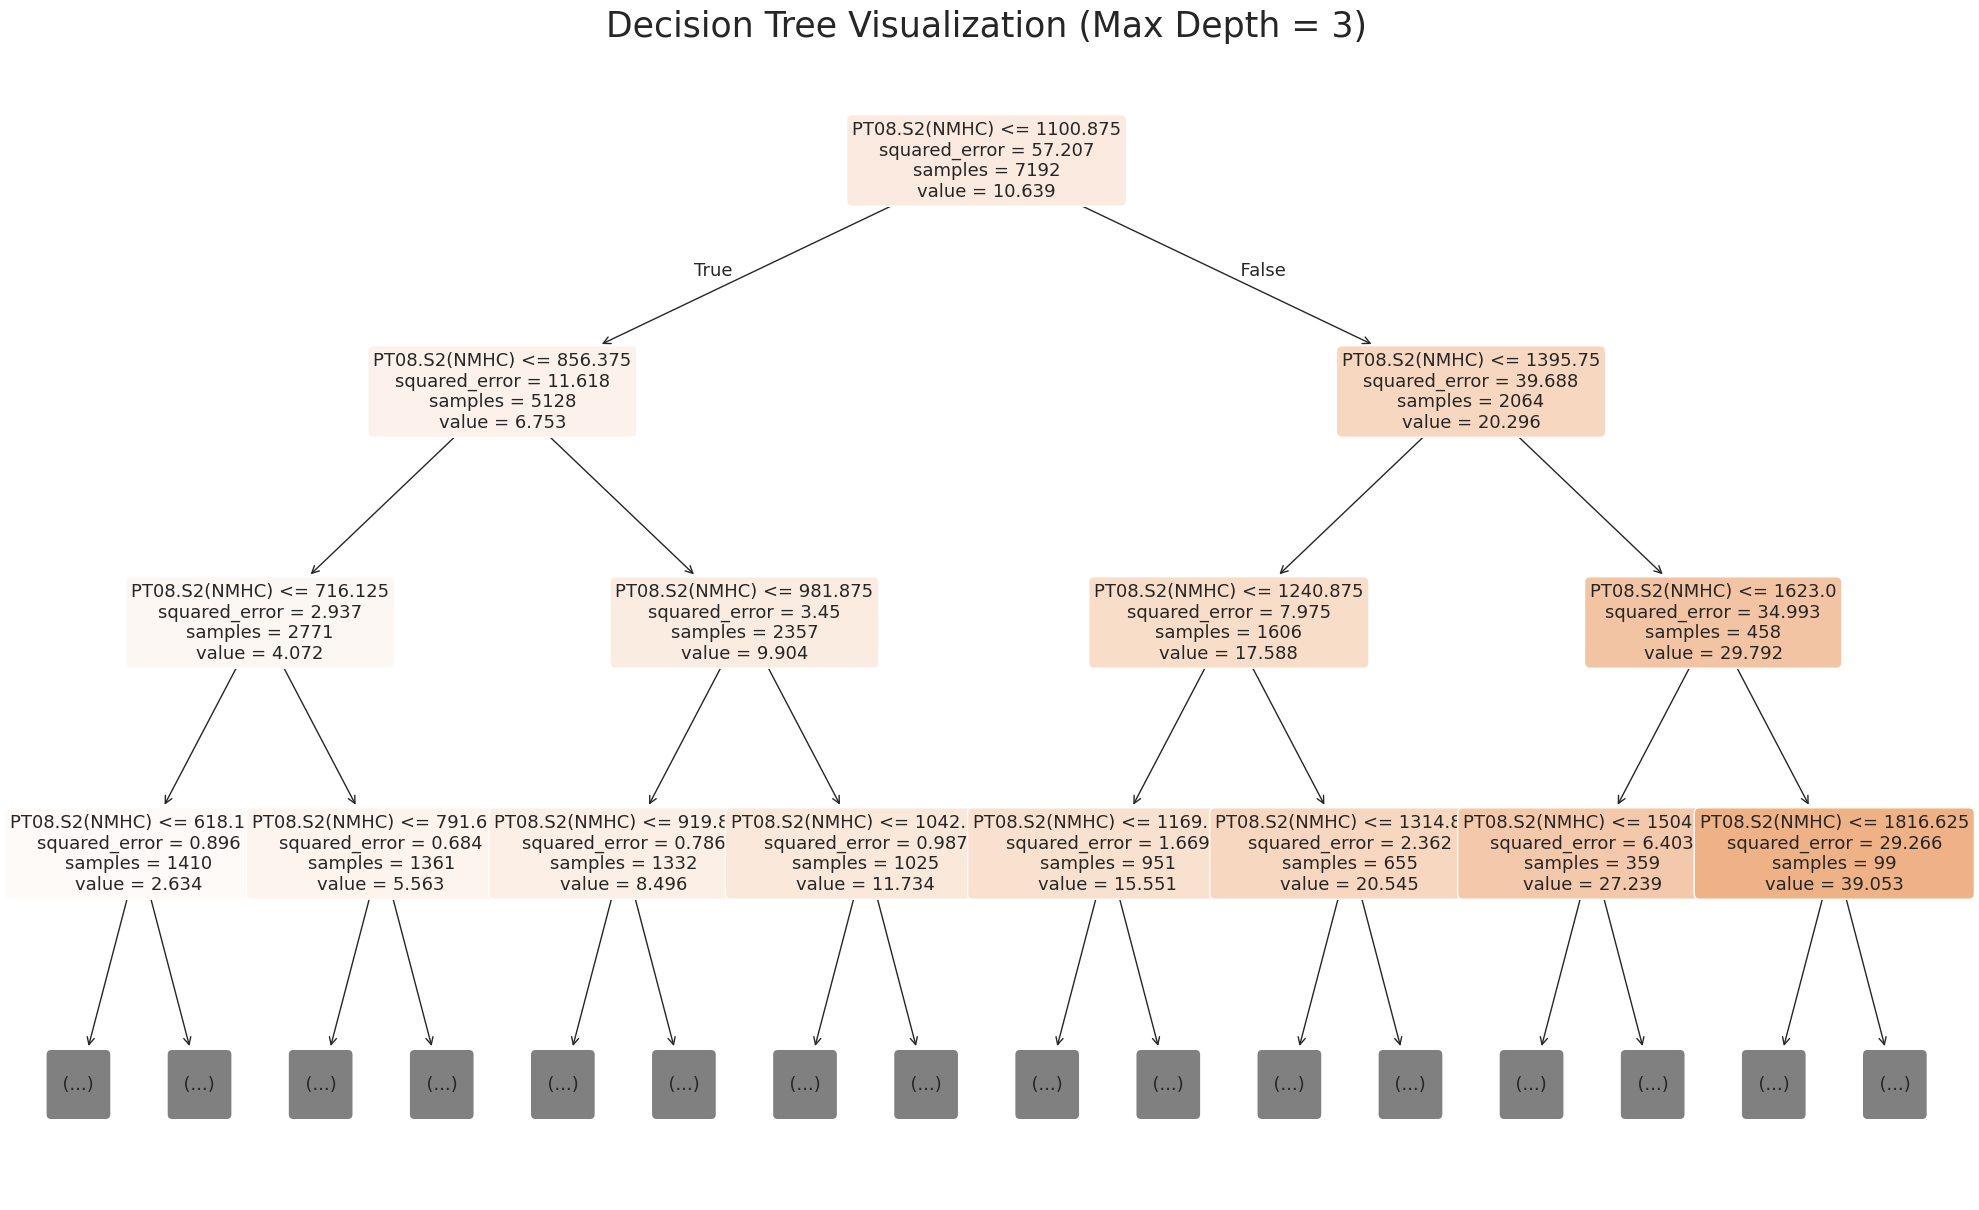

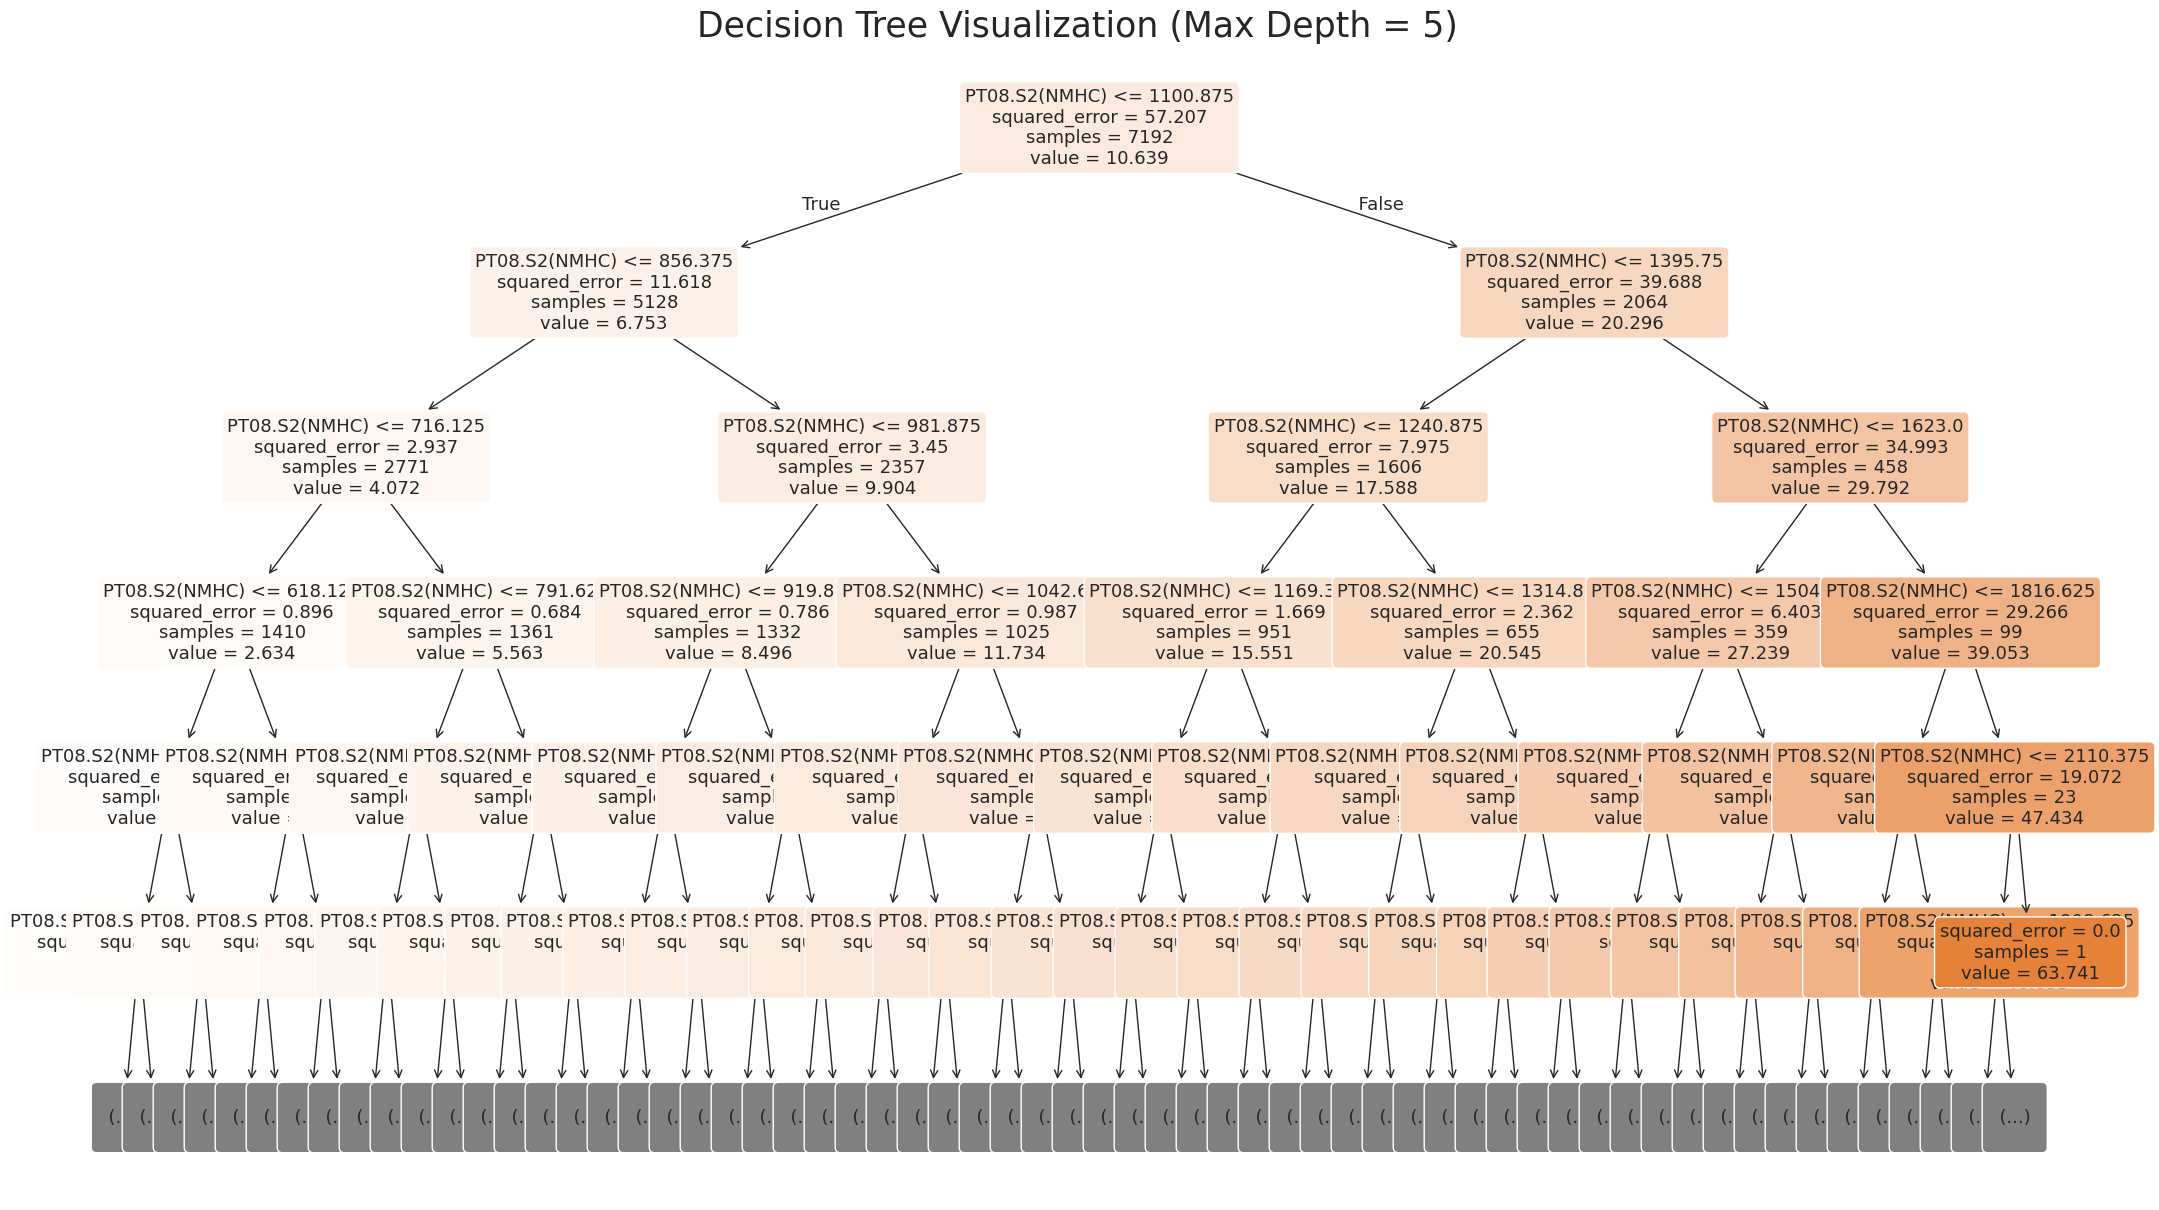

In [ ]:
depths = [2, 3, 5]

for depth in depths:
    plt.figure(figsize=(25, 15))
    plot_tree(
        dt_regressor,
        feature_names=X_train.columns,
        max_depth=depth,
        filled=True,
        rounded=True,
        fontsize=13
    )
    plt.title(f"Decision Tree Visualization (Max Depth = {depth})", fontsize=25)

The decision trees show different maximum depths (2, 3, and 5). However, they look very similar because the most important splits happen early in the tree. This suggests that a small tree is enough to understand the patterns in the data, which can also help avoid overfitting while still making accurate predictions. (we will see the feature dominance soon using lime and shap)

In [ ]:
param_grid = {
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_leaf_nodes': [None, 10, 20, 30, 50],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2']
}

dt_regressor = DecisionTreeRegressor()

grid_search = GridSearchCV(
    estimator=dt_regressor,
    param_grid=param_grid,
    scoring=['neg_mean_squared_error', 'r2'],
    refit='neg_mean_squared_error',
    verbose=1,
)

grid_search.fit(X_train, y_train)

results_df = pd.DataFrame(grid_search.cv_results_)

print("Best Parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

best_model = grid_search.best_estimator_

train_r2 = best_model.score(X_train, y_train)
print("Training R-squared:", train_r2)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Best Parameters: {'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best MSE: 0.04212915903285598
Training R-squared: 0.9998297344573432


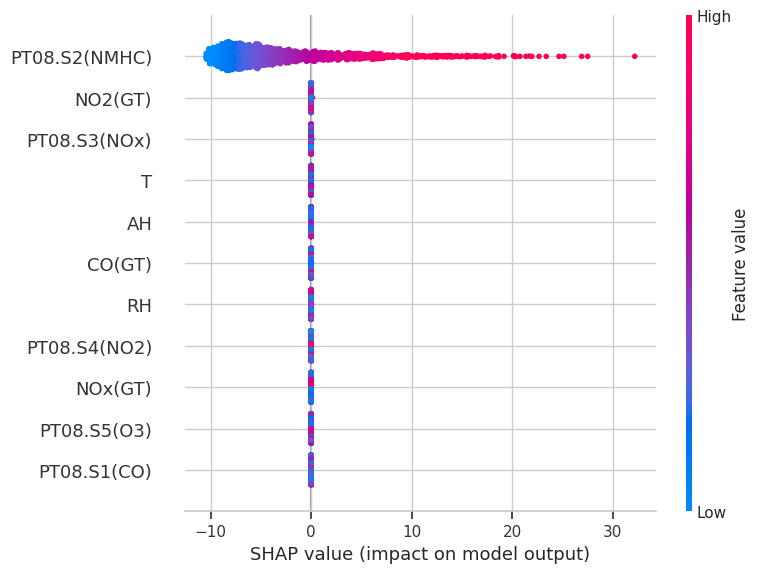

In [ ]:
dt_regressor = DecisionTreeRegressor()

dt_regressor.fit(X_train, y_train)

explainer = shap.TreeExplainer(dt_regressor)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


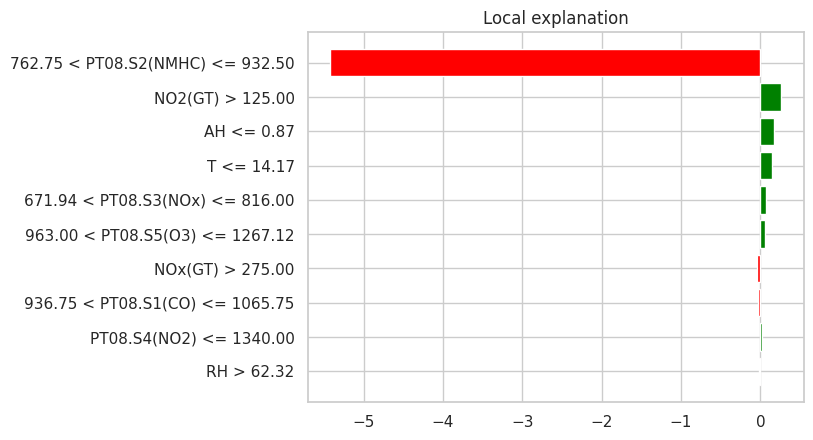

In [ ]:
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(X_train, y_train)

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    mode='regression',
    training_labels=y_train.values,
    feature_names=X_train.columns,
    discretize_continuous=True,
    class_names=['Prediction']
)

instance_to_explain = X_test.iloc[0]

explanation = explainer.explain_instance(instance_to_explain.values, dt_regressor.predict)

fig = explanation.as_pyplot_figure()

fig.patch.set_facecolor('white')
plt.gcf().set_facecolor('white')

Based on our SHAP and LIME interpretations, it’s clear that PT08.S2 is the most influential variable, significantly outweighing the impact of the others. This explains why the decision trees with different depths ended up looking similar—the dominant variable, PT08.S2, determined the key splits early on. In real-world terms, this means our target variable is primarily influenced by PT08.S2, with other variables playing a much smaller role

## **Random Forest Regressor**

In [ ]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 0.0025902930420852173
R-squared (R2): 0.99993897169866


And again we have absolutly stunning evaluation metrics for our random forest as well, lets now tune our model

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
}

rf_regressor = RandomForestRegressor()

grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    scoring=['neg_mean_squared_error', 'r2'],
    refit='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

results_df = pd.DataFrame(grid_search.cv_results_)

print("Best Parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

best_rf_model = grid_search.best_estimator_

train_r2 = best_rf_model.score(X_train, y_train)
print("Training R-squared:", train_r2)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best MSE: 0.0520326298988007
Training R-squared: 0.9999377447374302


Here is our tuned model's metrics as well

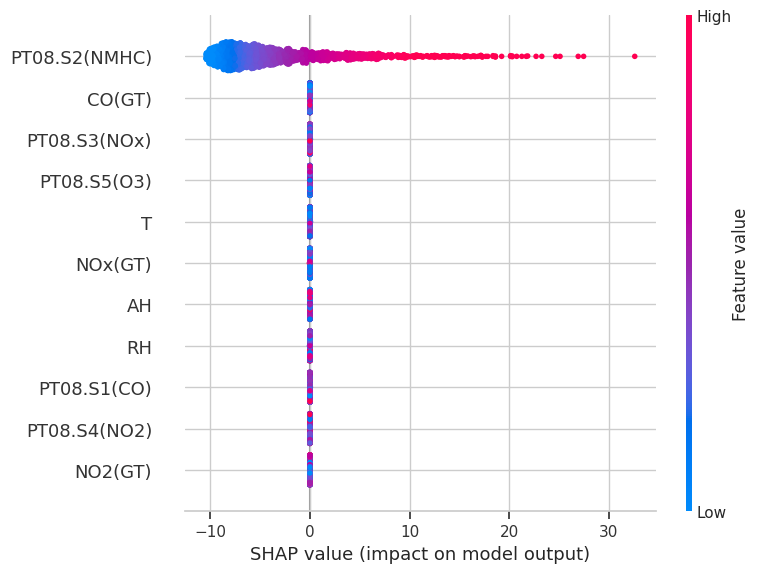

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


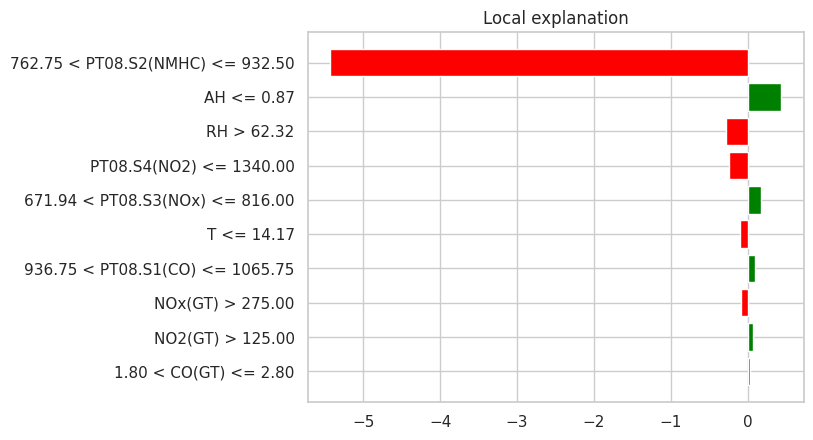

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    mode='regression',
    training_labels=y_train.values,
    feature_names=X_train.columns,
    discretize_continuous=True,
    class_names=['Prediction']
)

instance_to_explain = X_test.iloc[0]

explanation = explainer.explain_instance(instance_to_explain.values, best_model.predict)

fig = explanation.as_pyplot_figure()
fig.patch.set_facecolor('white')
plt.gcf().set_facecolor('white')

And again, not surprisingly, PT08.S2 variable dominates all the other variables significantly

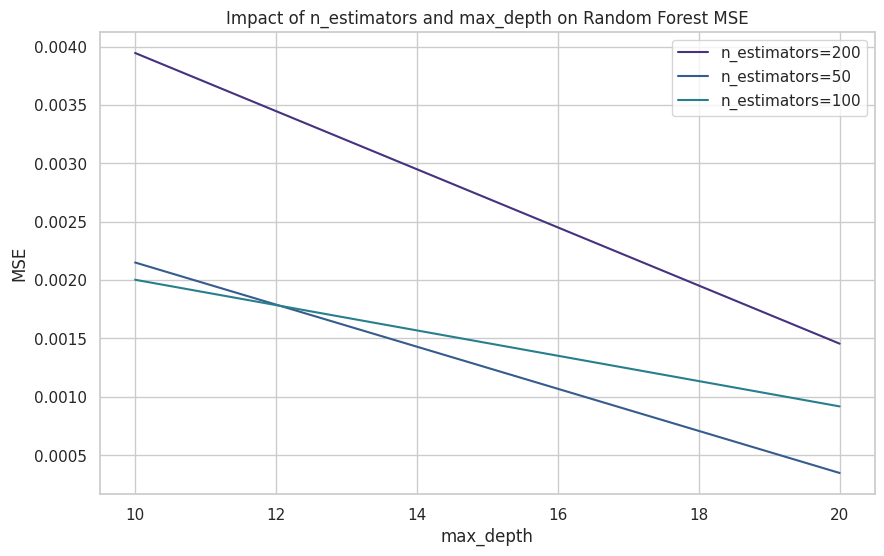

In [ ]:
n_estimators_list = [50, 100, 200]
max_depth_list = [10, 20, None]

mse_scores = []

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        rf_regressor = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf_regressor.fit(X_train, y_train)
        y_pred = rf_regressor.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append((n_estimators, max_depth, mse))

n_estimators_values = [item[0] for item in mse_scores]
max_depth_values = [item[1] for item in mse_scores]
mse_values = [item[2] for item in mse_scores]

fig, ax = plt.subplots(figsize=(10, 6))
for n_est in set(n_estimators_values):
  subset_data = [(md, mse) for ne, md, mse in mse_scores if ne==n_est]
  max_depths = [s[0] for s in subset_data]
  mses = [s[1] for s in subset_data]
  ax.plot(max_depths, mses, label=f"n_estimators={n_est}")

ax.set_xlabel("max_depth")
ax.set_ylabel("MSE")
ax.set_title("Impact of n_estimators and max_depth on Random Forest MSE")
ax.legend()

The graph shows the impact of n_estimators (number of trees) and max_depth (tree depth) on the Mean Squared Error (MSE) for a Random Forest model. As max_depth increases, the MSE decreases for all values of n_estimators, indicating better model performance. Additionally, higher n_estimators values (200) result in higher MSE compared to lower values (50), suggesting that increasing the number of trees may lead to overfitting in this case

## **XGBoost Regressor**

In [ ]:
xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 0.04594578121867468
R-squared (R2): 0.9989174997052608


XGBoost regressor also does the great job according to our R squared and MSE metrics

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.3, 0.05, 0.1],
    'max_depth': [3, 5, 6,10],
    'subsample': [1.0, 0.8],
    'colsample_bytree': [1.0, 0.8]
}

xgb_regressor = XGBRegressor()

grid_search = GridSearchCV(
    estimator=xgb_regressor,
    param_grid=param_grid,
    scoring=['neg_mean_squared_error', 'r2'],
    refit='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

results_df = pd.DataFrame(grid_search.cv_results_)

print("Best Parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

best_xgb_model = grid_search.best_estimator_

train_r2 = best_xgb_model.score(X_train, y_train)
print("Training R-squared:", train_r2)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best MSE: 0.17686628784026587
Training R-squared: 0.9999886489220505


Even tho our tuned model has a little worse MSE, our R squared is actually much better and our model seem amazing once again


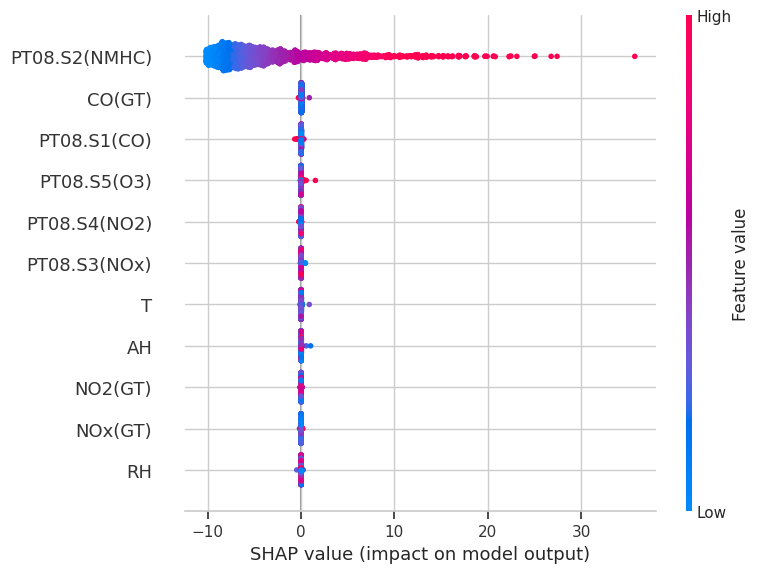

In [ ]:
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

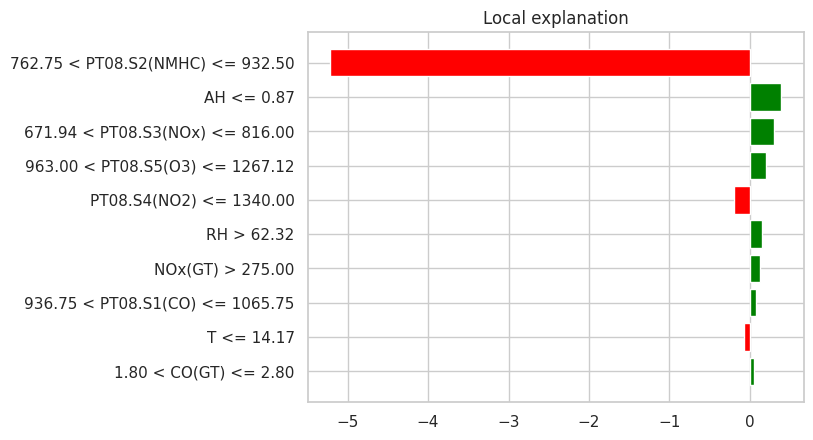

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    mode='regression',
    training_labels=y_train.values,
    feature_names=X_train.columns,
    discretize_continuous=True,
    class_names=['Prediction']
)

instance_to_explain = X_test.iloc[0]

explanation = explainer.explain_instance(instance_to_explain.values, best_xgb_model.predict)

fig = explanation.as_pyplot_figure()
fig.patch.set_facecolor('white')
plt.gcf().set_facecolor('white')

And the same picture as we have seen previously, one variable dominating over others due to high correlation bettween PT08.S2 and target variable

Text(0.5, 1.0, 'Effect of n_estimators on Model Performance')

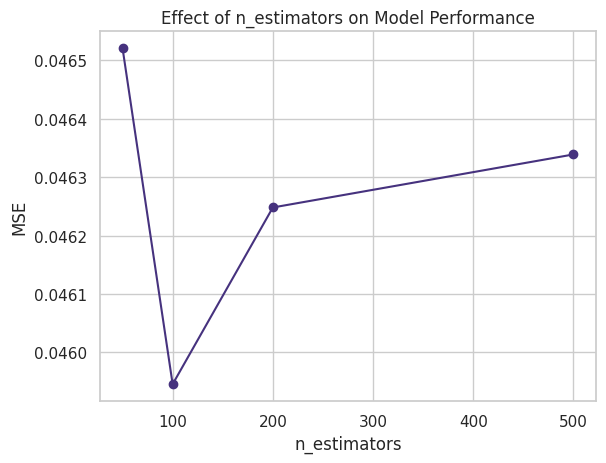

In [ ]:
n_estimators_range = [50, 100, 200, 500]
mse_scores = []

for n in n_estimators_range:
    model = XGBRegressor(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, y_pred))

plt.plot(n_estimators_range, mse_scores, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.title('Effect of n_estimators on Model Performance')

Graph above shows how different values of n_estimators change our MSE and according to it, and also on our tuning results, we have lowest MSE on 100 trees

# **Comparison**

First lets compare our 3 tree based models and their results to each other. The best results out of all three fine tuned models have been seen on our decision tree regressor with approximately 0.0003 MSE and 0.999998 R squared, which is phenomenal. We have already build a linear regression on this dataset before, where we get 0.99995 R squared and 0.0027 MSE which is also quite amazing but our tree based models take the win in this case with soo slight differences

# **Part 2: Introduction to Classification Problem**

### Weather Dataset Overview

- This dataset contains daily meteorological observations collected from a specific location. Each row represents a single day of weather data, capturing various meteorological variables. The objective is to analyze weather trends and predict outcomes such as rainfall based on the provided features.

### Feature Descriptions

- **Date** (date): The date of the observation.
- **Location** (categorical): The geographic location where the observation was recorded.
- **MinTemp** (numeric): Minimum temperature of the day (°C).
- **MaxTemp** (numeric): Maximum temperature of the day (°C).
- **Rainfall** (numeric): Total precipitation recorded for the day (mm).
- **Evaporation** (numeric): Amount of water evaporated (mm).
- **Sunshine** (numeric): Total hours of sunshine for the day.
- **WindGustDir** (categorical): Direction of the strongest wind gust.
- **WindGustSpeed** (numeric): Speed of the strongest wind gust (km/h).
- **WindDir9am** (categorical): Wind direction at 9 am.
- **WindDir3pm** (categorical): Wind direction at 3 pm.
- **WindSpeed9am** (numeric): Wind speed at 9 am (km/h).
- **WindSpeed3pm** (numeric): Wind speed at 3 pm (km/h).
- **Humidity9am** (numeric): Humidity percentage at 9 am.
- **Humidity3pm** (numeric): Humidity percentage at 3 pm.
- **Pressure9am** (numeric): Atmospheric pressure at 9 am (hPa).
- **Pressure3pm** (numeric): Atmospheric pressure at 3 pm (hPa).
- **Cloud9am** (numeric): Cloud cover at 9 am (measured in oktas).
- **Cloud3pm** (numeric): Cloud cover at 3 pm (measured in oktas).
- **Temp9am** (numeric): Temperature at 9 am (°C).
- **Temp3pm** (numeric): Temperature at 3 pm (°C).
- **RainToday** (categorical): Indicates whether it rained on the observation day (Yes/No).
- **RainTomorrow** (categorical): Target variable indicating whether it rained the following day (Yes/No).


# **Data Preprocessing**

Let's just discover some data issues and structure for further alterations

In [ ]:
df = pd.read_csv('weatherAUS.csv')

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
df.shape

(145460, 23)

As we see we got 145460 instances, with 22 independent and 1 target valeus

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

It seems like there are lots of nulls that should be taken care of accordingly. Datatypes seem alright at the first glance

In [ ]:
df.isna().sum()

,0
Date,0
Location,0
MinTemp,1485
MaxTemp,1261
Rainfall,3261
Evaporation,62790
Sunshine,69835
WindGustDir,10326
WindGustSpeed,10263
WindDir9am,10566


So as I said, we got lots of nulls, lets first get rid of the rows, of which all columns have null values, because it means they have not been filled so there is no use of them

In [ ]:
df = df[~df.drop(columns=['Date', 'Location']).isnull().all(axis=1)]

In [ ]:
df.isna().sum()

,0
Date,0
Location,0
MinTemp,1303
MaxTemp,1079
Rainfall,3079
Evaporation,62608
Sunshine,69653
WindGustDir,10144
WindGustSpeed,10081
WindDir9am,10384


In [ ]:
null_percentage = df.isnull().mean() * 100

null_percentage_table = pd.DataFrame(null_percentage, columns=['Null Percentage'])

null_percentage_table

,Null Percentage
Date,0.000000
Location,0.000000
MinTemp,0.896901
MaxTemp,0.742714
Rainfall,2.119385
Evaporation,43.095307
Sunshine,47.944630
WindGustDir,6.982475
WindGustSpeed,6.939110
WindDir9am,7.147675


As we can see, after deleting all the full null value rows, we still got pretty lot null values, above we can see percentage of null values for each column. Let's start taking care of all of them step-by-step and decide if we should impute them or just get rid of those with significanlty high null percentages

Text(0.5, 1.0, 'Correlation Matrix for Numerical Variables')

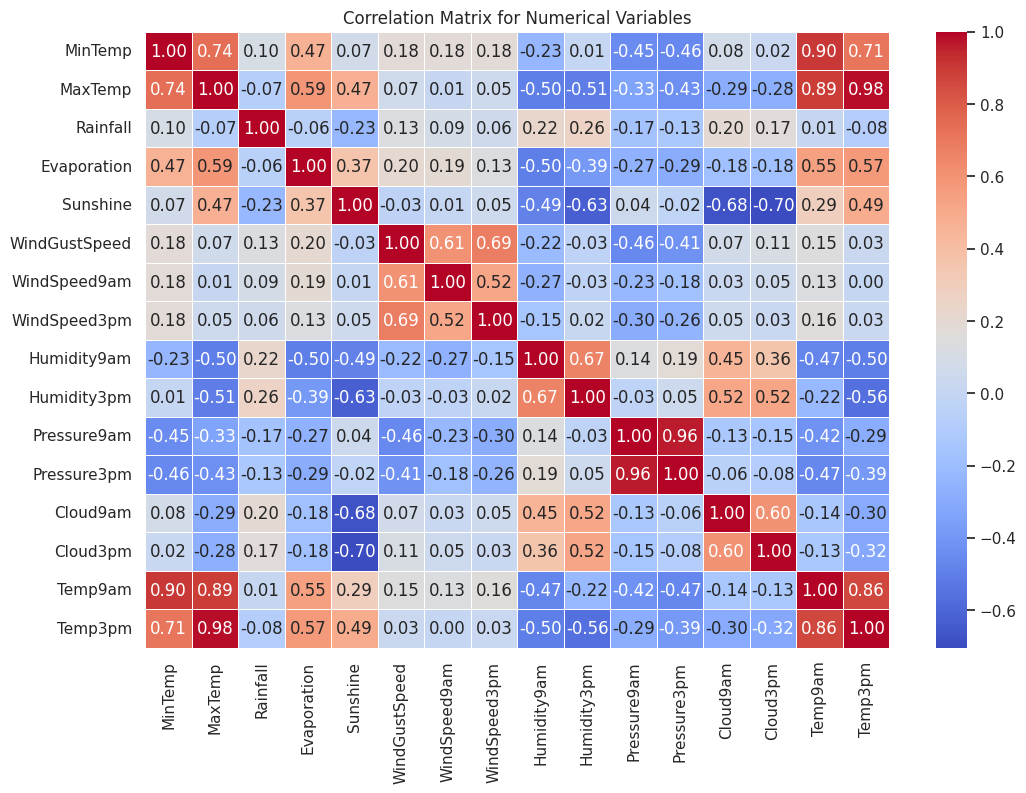

In [ ]:
numerical_columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                     'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
                     'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
                     'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

numerical_data = df[numerical_columns]

correlation_matrix = numerical_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix for Numerical Variables')

In [ ]:
df_non_null = df.dropna(subset=['RainTomorrow', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'])

data = df_non_null[['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'RainTomorrow']]

data['RainTomorrow'] = data['RainTomorrow'].map({'Yes': 1, 'No': 0})

correlation_matrix = data.corr()

print(correlation_matrix['RainTomorrow'])

Evaporation    -0.127151
Sunshine       -0.449260
Cloud9am        0.319135
Cloud3pm        0.389974
RainTomorrow    1.000000
Name: RainTomorrow, dtype: float64


<ipython-input-39-e373bc85998e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RainTomorrow'] = data['RainTomorrow'].map({'Yes': 1, 'No': 0})


Text(0.5, 1.0, 'Missing Data Heatmap')

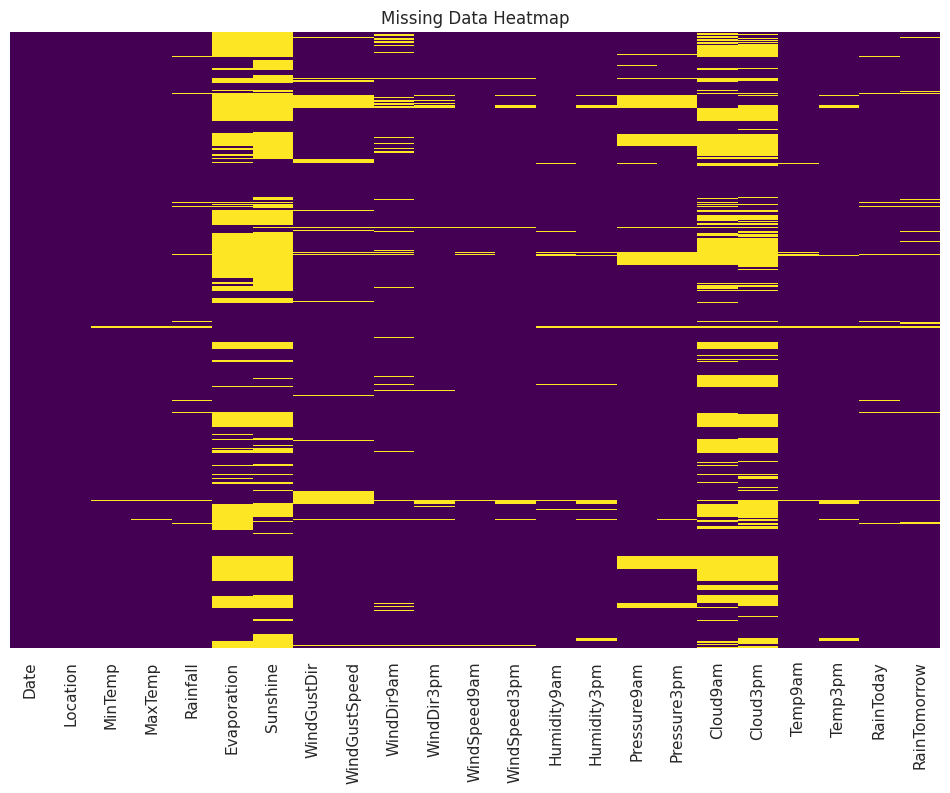

In [ ]:
missing_data = df.isnull().astype(int)

plt.figure(figsize=(12, 8))
sns.heatmap(missing_data, cmap='viridis', cbar=False, yticklabels=False)
plt.title('Missing Data Heatmap')

So based on the correlation matrix between numerical variables, null heatmap and correlation between high percentage null columns and target variable, excluding nulls, we can make some analysis. Firstly, Evaporation-Sunshine and Cloud9am-Cloud3pm this duos have some pattern of missingness, also we can see that cloudiness on both hour periods are decently correlated with the sunshine, and lastly, sunshine has the most meaningful correlation with the target variable compared to the other columns, so I decide to keep the sunshine column and drop the other three, due to high absence of values and insignificance.

In [ ]:
df = df.drop(columns=['Evaporation', 'Cloud9am', 'Cloud3pm'])

I will use mean imputation for all numerical variables of which missing values count are less than 10,000

In [ ]:
columns_to_impute = [
    'MinTemp', 'MaxTemp', 'Rainfall', 'Temp3pm', 'Temp9am',
    'Humidity3pm', 'Humidity9am', 'WindSpeed3pm', 'WindSpeed9am'
]

imputer = SimpleImputer(strategy='mean')

df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

Lets use KNN imputation method for the remaining numerical variables

In [ ]:
columns_to_impute_knn = [
    'Sunshine', 'WindGustSpeed',
    'Pressure9am', 'Pressure3pm'
]

knn_imputer = KNNImputer(n_neighbors=5)

df[columns_to_impute_knn] = knn_imputer.fit_transform(df[columns_to_impute_knn])

Now do the mode imputation for the categorical variables (it is not the best method but since they don't have many null values bias won't be the case)

In [ ]:
categorical_columns = ['WindDir9am', 'WindDir3pm', 'WindGustDir', 'RainToday', 'RainTomorrow']

mode_imputer = SimpleImputer(strategy='most_frequent')

df[categorical_columns] = mode_imputer.fit_transform(df[categorical_columns])

Done! we got rid of all null values, no lets do the encoding part

In [ ]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    print(f"Distinct values in '{col}':")
    print(df[col].unique())
    print('-' * 50)

Distinct values in 'Date':
['2008-12-01' '2008-12-02' '2008-12-03' ... '2008-01-29' '2008-01-30'
 '2008-01-31']
--------------------------------------------------
Distinct values in 'Location':
['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
--------------------------------------------------
Distinct values in 'WindGustDir':
['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' 'ENE' 'SSE' 'S' 'NW' 'SE' 'ESE'
 'E' 'SSW']
--------------------------------------------------
Di

In [ ]:
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

So I thought about what kind of encoding would be the best fit for the location variable, I think the best option is to do target endoding in terms of Rain tomorrow. It will give us probabilities of rain for the next day which would make this columns much more useful for classification task

In [ ]:
location_mean = df.groupby('Location')['RainTomorrow'].mean()

df['Location'] = df['Location'].map(location_mean)

And lastly we got Wind direction columns left.

There is no some particular pattern between these values unfortunately, which makes it harder to come up with the best encoding idea for it. I think the best fit shoud be the target encoding, let me explain why: So in theory the wind direction should be altering the cloud movement, and in differenct countries the different wind direction would have different rain outcome, and based on this logical theory I think we should base our encodre on the relationship between wind directions in locations and the approximate probability of rain.

In [ ]:
def target_encode(df, feature_cols, target_col):
    for col in feature_cols:
        encoding = df.groupby([col, 'Location'])[target_col].mean().reset_index()
        encoding = encoding.rename(columns={target_col: f'{col}_encoded'})

        df = df.merge(encoding, on=[col, 'Location'], how='left')

    return df

columns_to_encode = ['WindDir9am', 'WindDir3pm', 'WindGustDir']

df = target_encode(df, columns_to_encode, 'RainTomorrow')

In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns

categorical_columns = [col for col in categorical_columns if col != 'Date']

df = df.drop(columns=categorical_columns)

In [ ]:
df.head().T

,0,1,2,3,4
Date,2008-12-01,2008-12-02,2008-12-03,2008-12-04,2008-12-05
Location,0.20349,0.20349,0.20349,0.20349,0.20349
MinTemp,13.4,7.4,12.9,9.2,17.5
MaxTemp,22.9,25.1,25.7,28.0,32.3
Rainfall,0.6,0.0,0.0,0.0,1.0
Sunshine,5.72,9.18,6.32,5.9,6.92
WindGustSpeed,44.0,44.0,46.0,24.0,41.0
WindSpeed9am,20.0,4.0,19.0,11.0,7.0
WindSpeed3pm,24.0,22.0,26.0,9.0,20.0
Humidity9am,71.0,44.0,38.0,45.0,82.0


In [ ]:
df = df.sort_values(by='Date')

X = df.drop(columns=["RainTomorrow", "Date"])
y = df["RainTomorrow"]

tscv = TimeSeriesSplit(n_splits=5)

splits = []
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    splits.append((X_train, X_test, y_train, y_test))

print("First Training Split Shape:", X_train.shape)
print("First Test Split Shape:", X_test.shape)

First Training Split Shape: (121065, 18)
First Test Split Shape: (24213, 18)


# **Model Building and Evaluation**

## **Decision Tree Classifier**

In [ ]:
dt_classifier = DecisionTreeClassifier()

dt_classifier.fit(X_train, y_train)

y_pred = dt_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.7714450914797836

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85     18749
           1       0.49      0.52      0.51      5464

    accuracy                           0.77     24213
   macro avg       0.68      0.68      0.68     24213
weighted avg       0.78      0.77      0.77     24213


Confusion Matrix:
 [[15854  2895]
 [ 2639  2825]]


We get not the best evaluation metrics here so lets tune our hyperparameters to find the best ones for our model

In [ ]:
param_grid = {
    'max_depth': [None, 5,10],
    'min_samples_split': [2, 5],
    'max_leaf_nodes': [None, 30, 50],
    'min_samples_leaf': [1, 2],
    'max_features': [None, 'sqrt'],
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid,
    scoring='accuracy',
    refit=True,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_

train_accuracy = best_model.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

y_pred = best_model.predict(X_test)

print("Classification Report for the Tuned Model:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'max_depth': None, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Accuracy: 0.83891298063024
Training Accuracy: 0.8427456325114608
Classification Report for the Tuned Model:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     18749
           1       0.70      0.44      0.54      5464

    accuracy                           0.83     24213
   macro avg       0.78      0.69      0.72     24213
weighted avg       0.82      0.83      0.82     24213



The tuned model achieved an accuracy of 83%, an improvement from 77% before tuning. The model performs well for the majority class (0), with a recall of 0.95, but struggles with the minority class (1), with a recall of 0.44. Overall, the tuning improved the model's performance.

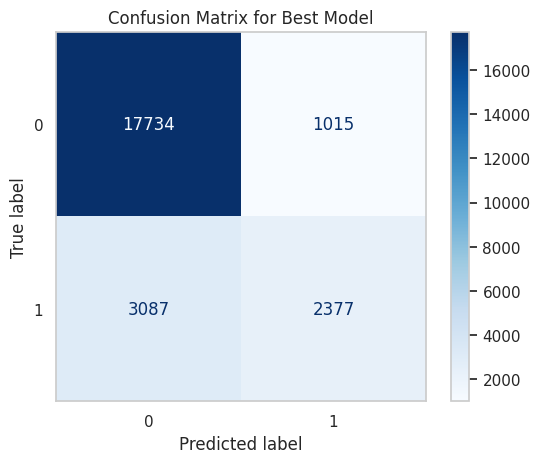

In [ ]:
y_pred_best = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_best)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Best Model")
plt.grid(False)

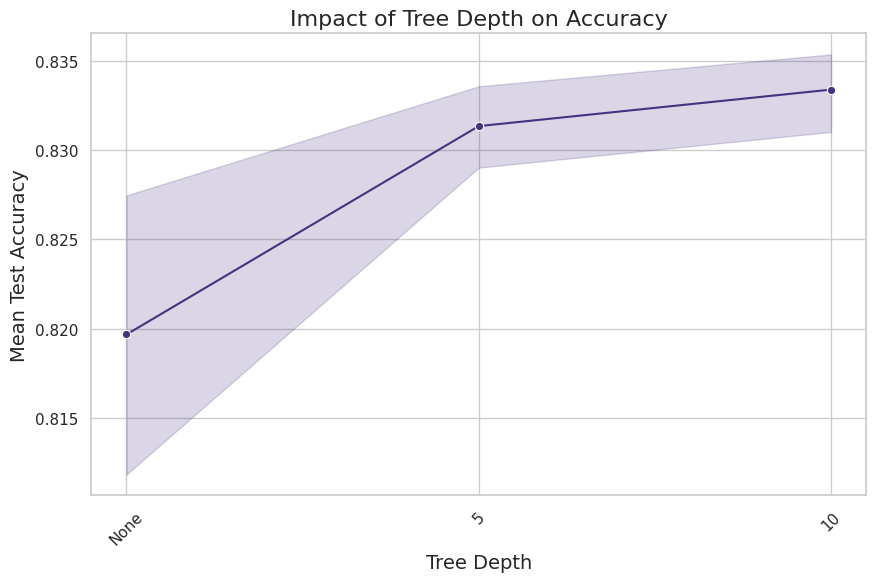

In [ ]:
results_df = pd.DataFrame(grid_search.cv_results_)

param_name = 'param_max_depth'
plt.figure(figsize=(10, 6))

results_df[param_name] = results_df[param_name].astype(str)
sns.lineplot(
    x=param_name,
    y='mean_test_score',
    data=results_df,
    marker='o'
)

plt.title("Impact of Tree Depth on Accuracy", fontsize=16)
plt.xlabel("Tree Depth", fontsize=14)
plt.ylabel("Mean Test Accuracy", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)

Here above is the graph which shows how the tree depths change our accuracy, as you can see we have the best accuracy of around 0.8325 for the depth of 10

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


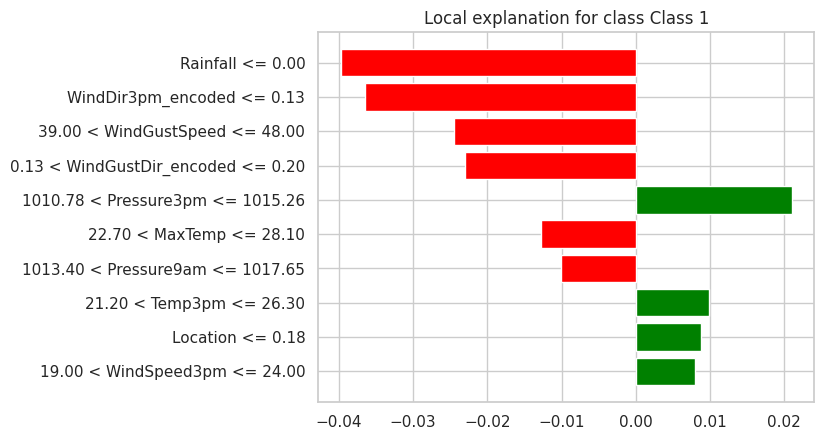

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    mode='classification',
    training_labels=y_train.values,
    feature_names=X_train.columns,
    discretize_continuous=True,
    class_names=['Class 0', 'Class 1']
)

instance_to_explain = X_test.iloc[0]
explanation = explainer.explain_instance(instance_to_explain.values, best_model.predict_proba)

fig = explanation.as_pyplot_figure()
fig.patch.set_facecolor('white')
plt.gcf().set_facecolor('white')

Here, there is no certain dominance of any of the variables like the regression problem. As we can see the Rainfall variable has slightly higher influence on the target variables, and the WindSpeed3pm having the lowest impact on our prediction

## **Random Forest Classifier**

In [ ]:
rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.8498327344814769

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91     18749
           1       0.75      0.50      0.60      5464

    accuracy                           0.85     24213
   macro avg       0.81      0.73      0.75     24213
weighted avg       0.84      0.85      0.84     24213


Confusion Matrix:
 [[17829   920]
 [ 2716  2748]]


Random forest gives us much better results than the decision tree, even without the fine tuning it has 0.85 accuracy which is pretty decent, now lets tune our model and see what enhancements we can get

In [ ]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

best_rf = grid_search.best_estimator_

y_pred_best = best_rf.predict(X_test)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Accuracy: 0.8545574691281543
Accuracy on Test Set: 0.8502870358898112
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91     18749
           1       0.75      0.51      0.60      5464

    accuracy                           0.85     24213
   macro avg       0.81      0.73      0.76     24213
weighted avg       0.84      0.85      0.84     24213



So again, due to high run times, I could not tune variaty of hyperparameter values unfortunately, thats why we got the same metrics, but in general our tuning should be finding the best sets of hyperparameters and yielding us much better metrics

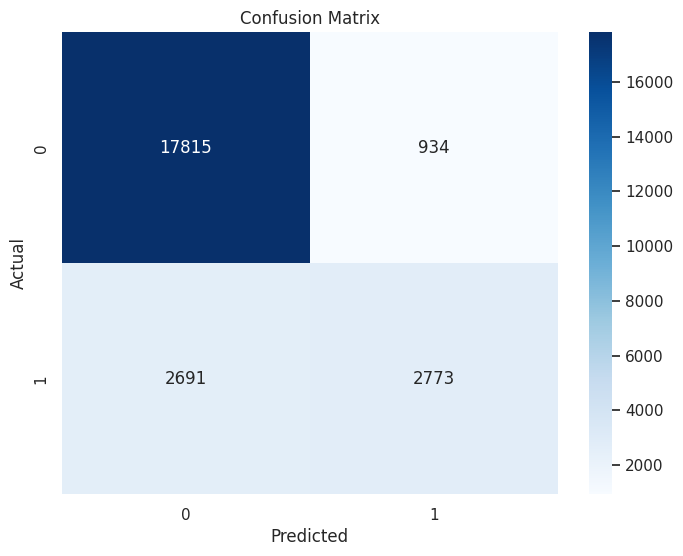

In [ ]:
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_rf.classes_, yticklabels=best_rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.grid(False)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Text(91.25, 0.5, 'Number of Estimators')

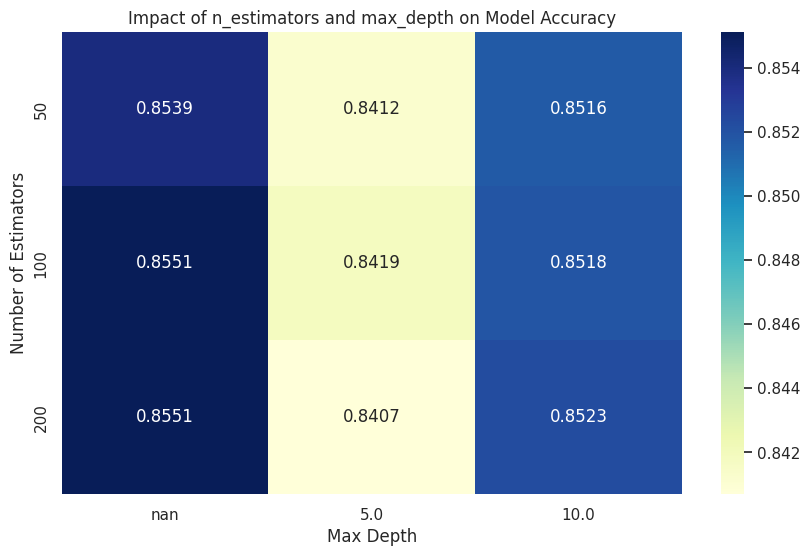

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    scoring='accuracy',
    refit=True,
    verbose=1
)

grid_search.fit(X_train, y_train)

cv_results = pd.DataFrame(grid_search.cv_results_)

results = cv_results[['param_n_estimators', 'param_max_depth', 'mean_test_score']]
pivot_results = results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_results, annot=True, cmap="YlGnBu", fmt=".4f")
plt.title("Impact of n_estimators and max_depth on Model Accuracy")
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")

The matrix above illustrates the accuracy being impacted by the different max depth of trees and numebr of trees, as you can see we have the highest accuracy for the 200 and 100 trees that have no maximum depths and the lowest for the 5 tree depthes for 200 trees

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


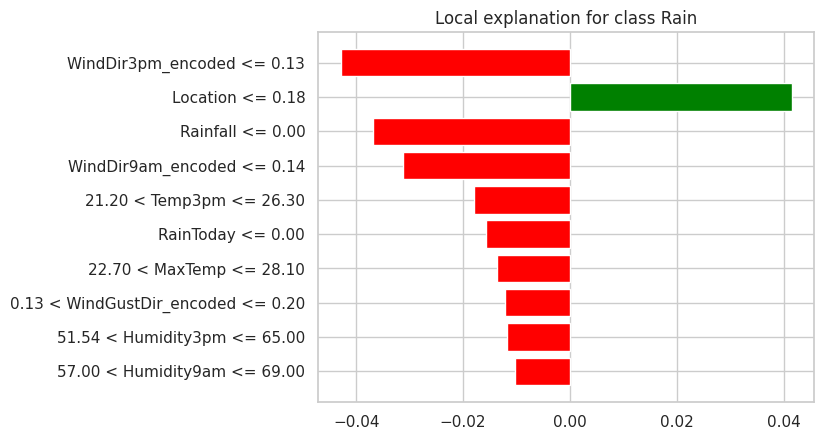

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    mode='classification',
    training_labels=y_train.values,
    feature_names=X_train.columns,
    discretize_continuous=True,
    class_names=['No Rain', 'Rain']
)

instance_to_explain = X_test.iloc[0]
explanation = explainer.explain_instance(instance_to_explain.values, best_rf.predict_proba)

fig = explanation.as_pyplot_figure()
fig.patch.set_facecolor('white')
plt.gcf().set_facecolor('white')

So here again, there is no certain dominance of any of the variables like the regression problem. As we can see the Rainfall variable has slightly higher influence on the target variables, and the WindSpeed3pm having the lowest impact on our prediction

## **XGBoost Classifier**

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

weights_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights:", weights_dict)

scale_pos_weight = weights_dict[0] / weights_dict[1]
print("Scale Pos Weight:", scale_pos_weight)

xgb_classifier = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)

xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy (with weighting):", accuracy)

print("\nClassification Report (with weighting):\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix (with weighting):\n", conf_matrix)

Class Weights: {0: 0.6395268985335756, 1: 2.2917692045583613}
Scale Pos Weight: 0.2790537970671512
Accuracy (with weighting): 0.8370709949200843

Classification Report (with weighting):
               precision    recall  f1-score   support

           0       0.83      0.98      0.90     18749
           1       0.86      0.33      0.48      5464

    accuracy                           0.84     24213
   macro avg       0.85      0.66      0.69     24213
weighted avg       0.84      0.84      0.81     24213


Confusion Matrix (with weighting):
 [[18451   298]
 [ 3647  1817]]


Here I used weighting for the imbalance problem in target variable for XGBoost model and we got pretty good results again with 0.84 accuracy

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.3],
    'max_depth': [6, 10],
    'min_child_weight': [1, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

best_xgb = grid_search.best_estimator_

y_pred_best = best_xgb.predict(X_test)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Best Accuracy: 0.85161690001239
Accuracy on Test Set: 0.8460744228307108
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91     18749
           1       0.83      0.40      0.54      5464

    accuracy                           0.85     24213
   macro avg       0.84      0.69      0.72     24213
weighted avg       0.84      0.85      0.82     24213



The tuned XGBoost model showed improvements over the untuned version. While both models had similar overall accuracy (around 84-85%), tuning significantly boosted recall for the minority class from 33% to 40%. This resulted in a better balance between precision and recall, with the weighted F1-score increasing from 81% to 82%. Overall, tuning helped the model better handle class imbalance.


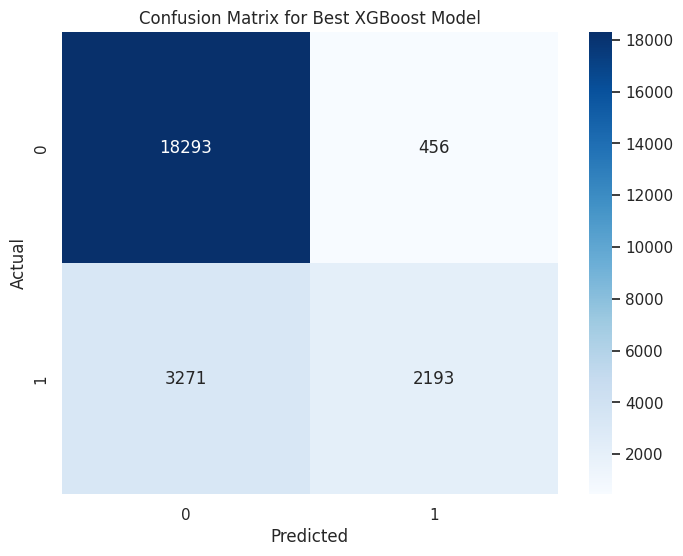

In [ ]:
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_xgb.classes_, yticklabels=best_xgb.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Best XGBoost Model')
plt.grid(False)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Text(91.25, 0.5, 'Number of Estimators')

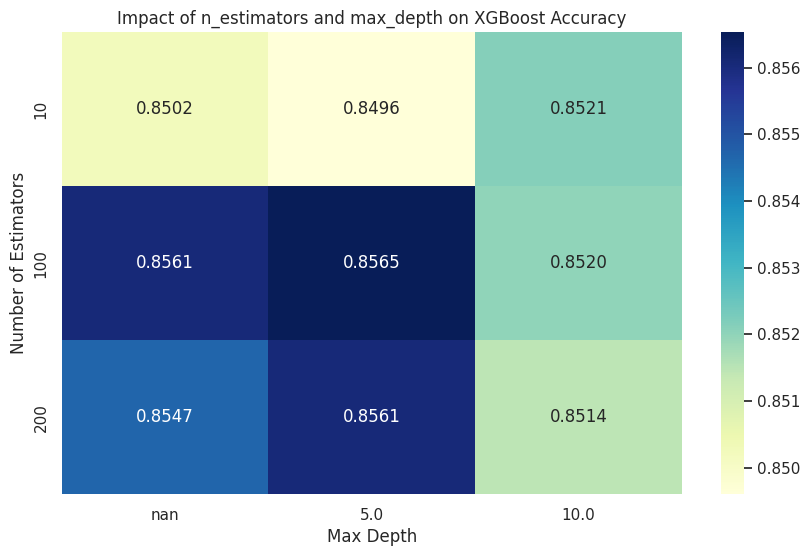

In [ ]:
param_grid_impact = {
    'n_estimators': [10, 100, 200],
    'max_depth': [5, 10, None],
}

grid_search_impact = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=param_grid_impact,
    scoring='accuracy',
    refit=True,
    verbose=1
)

grid_search_impact.fit(X_train, y_train)

cv_results = pd.DataFrame(grid_search_impact.cv_results_)

results = cv_results[['param_n_estimators', 'param_max_depth', 'mean_test_score']]
pivot_results = results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_results, annot=True, cmap="YlGnBu", fmt=".4f")
plt.title("Impact of n_estimators and max_depth on XGBoost Accuracy")
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")

On the matrix above we have illustrated how different tree depths and number of trees impact our accuracy. As we can see we have the highest accuracy for the 100 trees with the depth of 5 and the lowest for also 5 depth but for the 10 estimators

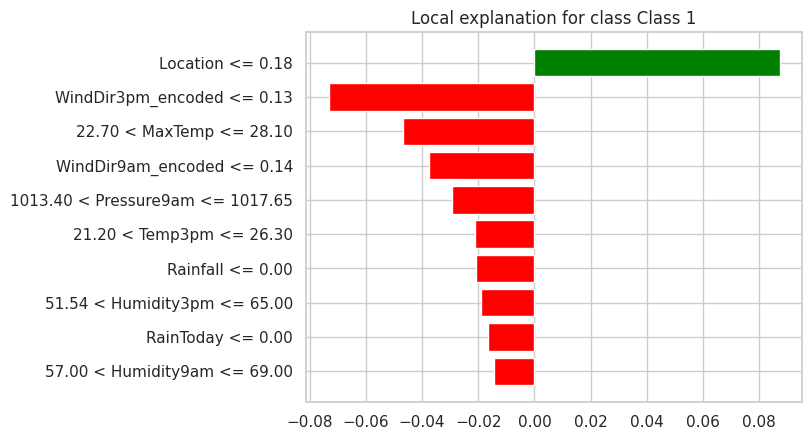

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    mode='classification',
    training_labels=y_train.values,
    feature_names=X_train.columns,
    discretize_continuous=True,
    class_names=['Class 0', 'Class 1']
)

instance_to_explain = X_test.iloc[0]
explanation = explainer.explain_instance(instance_to_explain.values, best_xgb.predict_proba)

fig = explanation.as_pyplot_figure()
fig.patch.set_facecolor('white')
plt.gcf().set_facecolor('white')

The graph shows how different weather features (like temperature, wind direction, humidity, and rainfall) influence the prediction for Class 1 (a specific outcome in the model). Each bar represents a feature, and its length and color show whether the feature increased (green) or decreased (red) the prediction.
- The top feature (Location), shown in green, had the strongest positive impact on the prediction.
- Other features, like Wind Direction, Max Temperature, and Pressure, shown in red, had a negative impact on the prediction.
- Features lower down, such as Humidity and Rainfall, also had smaller negative influences.

In short, the graph helps identify which factors were most important for the prediction and whether they pushed the model’s decision up or down.